---

**Lesson 5** of the YT course:

[***Machine Learning for Audio Signals in Python - MLfAS***](https://www.youtube.com/playlist?list=PL6QnpHKwdPYjfCH2zkMGEHu2kv1HTICYA)

Original Jupyter Notebooks by [*Renato Profeta*](https://www.youtube.com/c/GuitarsAI)

---

In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time

device='cpu'
#device='cuda'

#Convolutional Neural Networks
###for the MNIST dataset

We can compare this with the case of our fully connected network, and will see that indeed we only have a fraction of the weights in our convolutional network compared with the fully connected network. 

We can then train the convolutional network as before. Here we see a disadvantage: it takes much longer to train, we need 1000 iterations or more to obtain a good solution, as compared to only 10 iterations for the fully connected network!

In [2]:
batch_size_train = 100
batch_size_test = 10
num_classes = 10

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=False)

#the Normalize numbers are mean and standard deviation.
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
examples = enumerate(train_loader)
# Plot ad hoc mnist instances

# load (downloaded if needed) the MNIST dataset
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#one batch of 100 images:
batch_idx, (X_train, y_train) = next(examples)
print("batch_idx=", batch_idx, "X_train.shape=", X_train.shape, "y_train.shape=", y_train.shape, "y_train=", y_train)
examples = enumerate(test_loader)
#one batch of 100 images:
batch_idx, (X_test, y_test) = next(examples)

batch_idx= 0 X_train.shape= torch.Size([100, 1, 28, 28]) y_train.shape= torch.Size([100]) y_train= tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1])


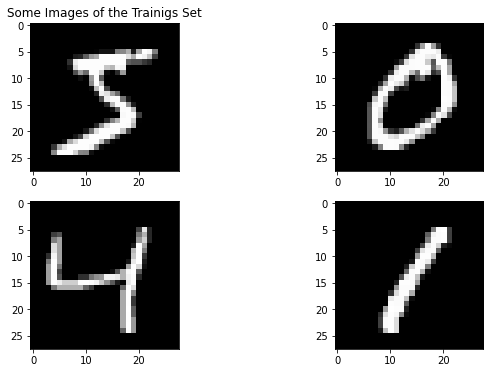

In [4]:
# plot 4 images as gray scale
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.title("Some Images of the Trainigs Set")
plt.imshow(X_train[0,0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1,0], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2,0], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3,0], cmap=plt.get_cmap('gray'))
# show the plot


X_testunflat=X_test.clone() #keep original for imshow later
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[2] * X_train.shape[3]

In [5]:
# define baseline model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20, 10)

    def forward(self, x):
        #print("x_input.shape=", x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 4))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("x.shape=", x.shape)
        x = x.view(-1, 20) #80 for pool: 2,4; ((((28-(5-1))/2-(5-1))/4)**2)*20
        #20 for pool: 4,2: ((((28-(5-1))/4-(5-1))/2)**2)*20
        x = F.relu(self.fc1(x)) #10 outputs, 1 for each class.
        return x #F.log_softmax(x)

In [6]:
# build the model
print("Generate Model:")
model = ConvNet()#.to('cpu')
    
loss_fn = nn.CrossEntropyLoss()
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

try:
    checkpoint = torch.load("mnistexample_pytorch_convnet2_weights.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Read weights from mnistexample_pytorch_convnet2_weights.torch")
except IOError:
    print("fresh start")

Generate Model:
fresh start


In [7]:
# Fit the model
X_train=X_train.to(device)
y_train=y_train.to(device)
starttime=time.time()
for epoch in range(1000):
    Ypred=model(X_train)
    loss=loss_fn(Ypred, y_train)
    if epoch%2==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
endtime=time.time()
print("Duration of optimization:", endtime-starttime)

#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200, verbose=2)
# Final evaluation of the model
Ypred=model(X_test)
loss=loss_fn(Ypred, y_test)
#scores = model.forward(X_test, y_test, verbose=0)
print("Loss on the test set:", loss)

0 2.296931505203247
2 2.223421335220337
4 2.168954372406006
6 2.1084108352661133
8 2.0458524227142334
10 1.9849615097045898
12 1.9257729053497314
14 1.8626489639282227
16 1.7976809740066528
18 1.7325695753097534
20 1.6664565801620483
22 1.5992649793624878
24 1.531556248664856
26 1.4645122289657593
28 1.398155689239502
30 1.3321090936660767
32 1.2661036252975464
34 1.201568603515625
36 1.1400874853134155
38 1.0811131000518799
40 1.025301456451416
42 0.9731848835945129
44 0.9241722822189331
46 0.8788991570472717
48 0.8373676538467407
50 0.7993966937065125
52 0.764357328414917
54 0.7326033115386963
56 0.7035648822784424
58 0.6771552562713623
60 0.6529984474182129
62 0.6312195062637329
64 0.6118699312210083
66 0.5943988561630249
68 0.5787470936775208
70 0.5647813677787781
72 0.5526978969573975
74 0.5418027639389038
76 0.5321324467658997
78 0.5233944058418274
80 0.5156375169754028
82 0.5086217522621155
84 0.5023413300514221
86 0.4967234432697296
88 0.49164026975631714
90 0.48704689741134644

Wrote to mnistexample_pytorch_convnet2_weights.torch
sample.shape= torch.Size([1, 1, 28, 28])
prediction= tensor(5)


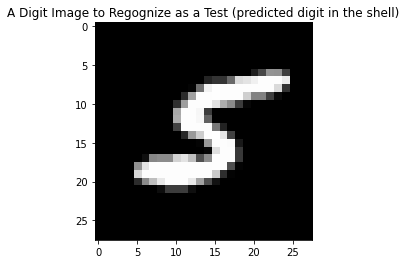

In [8]:
torch.save({
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "mnistexample_pytorch_convnet2_weights.torch")
print("Wrote to mnistexample_pytorch_convnet2_weights.torch")

plt.figure()
plt.imshow(X_testunflat[3,0], cmap=plt.get_cmap('gray'))
plt.title("A Digit Image to Regognize as a Test (predicted digit in the shell)")

sample=X_test[3,:]
sample=sample[None,:,:,:] #add the batch dimension for conv2d input.
print("sample.shape=", sample.shape)
prediction=torch.argmax(model(sample))
print("prediction=", prediction)

#1-D Convolutional Networks for Audio Processing

###A 1-D Signal Detector

Simple program to use a convolutional neural network to obtain a signal detector (peak detector) like matched filter, using pytorch.


In [9]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Device configuration
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def signal2pytorch(x):
    #Function to convert a signal vector s, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    #Argument x: a 1-d signal as numpy array
    #output: 3-d Tensor X for conv1d input.
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.detector=nn.Sequential(nn.Conv1d(in_channels=1, out_channels=1, kernel_size=11, stride=1, padding=10, bias=False))
        #self.detector=nn.Conv1d(1, 1, 8, padding=8, stride=1, bias=False)
   
    def forward(self, x):
        out = self.detector(x)
        return out

In [14]:
#Input signal X, a Ramp function:
x= np.hstack((np.zeros(4),np.arange(0,1.1,0.1),np.zeros(5)))
print("x=", x)
X=signal2pytorch(x)
y = np.zeros(30)
y[16]=1 #Detecting the signal at its end (for convolution padding='causal'), like a matched filter.
print("y=", y)
Y=signal2pytorch(y)
    
print("Input X[0,0,:]=", X[0,0,:], "X.shape=", X.shape )
print("Target Y[0,0,:]=", Y[0,0,:], "Y.shape=", Y.shape)
    
print("Generate Model:")
#model = generate_model()     # Compile an neural net
model = ConvNet()#.to('cpu')
print("Def. loss function:")
loss_fn = nn.MSELoss(reduction='sum')
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

for epoch in range(5000):
    Ydet=model(X)
    loss=loss_fn(Ydet, Y)
    if epoch%100==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

x= [0.  0.  0.  0.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.  0.
 0.  0. ]
y= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Input X[0,0,:]= tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000, 0.3000, 0.4000,
        0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000]) X.shape= torch.Size([1, 1, 20])
Target Y[0,0,:]= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) Y.shape= torch.Size([1, 1, 30])
Generate Model:
Def. loss function:
0 2.446884870529175
100 1.322016716003418
200 0.989430844783783
300 0.7523643970489502
400 0.5759210586547852
500 0.4454662501811981
600 0.34947916865348816
700 0.27865731716156006
800 0.22587823867797852
900 0.18593581020832062
1000 0.15511640906333923
1100 0.13080571591854095
1200 0.11118647456169128
1300 0.0950159877538681
1400 0.08146114647388458
1500 0.0699

In [16]:
torch.save(model.state_dict(), 'model_detector.torch')
Ydet=model(X)
Ydet=Ydet.data.numpy()
#xnoisy=x+np.random.normal(size=x.shape)*0.1
xnoisy=x+np.random.rand(20)-0.5
Xnoisy=signal2pytorch(xnoisy)
Ydetnoisy=model(Xnoisy)
Ydetnoisy=Ydetnoisy.data.numpy()
print("Predictions= ", Ydet[0,0,:])
weights=list(model.parameters())
print("Pytorch weights=", weights[0].data.numpy())

Predictions=  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  6.5159625e-03 -7.6918483e-02 -6.1049335e-02
 -4.5723423e-02 -3.0798268e-02 -1.6138505e-02 -1.6137228e-03
  1.2904232e-02  2.7543068e-02  4.2433135e-02 -1.4275610e-02
  9.8362976e-01 -1.0308479e-02 -5.2350741e-03 -1.1858940e-03
  1.7753533e-03  3.5667352e-03  4.0847771e-03  3.2028116e-03
  7.6883374e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Pytorch weights= [[[ 7.6883374e-04  2.5108613e-03  1.2099351e-03 -6.9079069e-05
   -1.3493266e-03 -2.6541250e-03 -4.0074703e-03 -5.4324418e-03
    9.9303597e-01 -8.9950407e-01  6.5159626e-02]]]


Y= tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


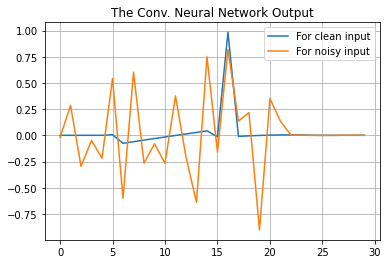

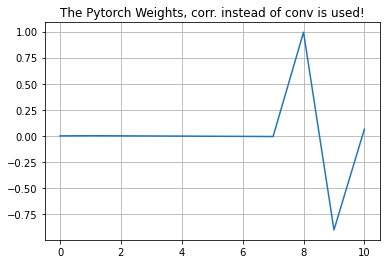

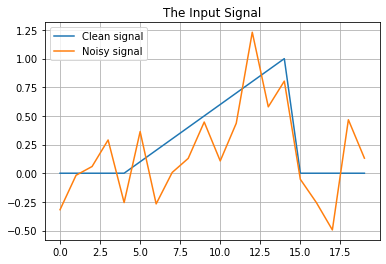

In [17]:
print("Y=", Y)
plt.figure()
plt.plot()
plt.plot(Ydet[0,0,:])
plt.plot(Ydetnoisy[0,0,:])
plt.legend(('For clean input', 'For noisy input'))
plt.title('The Conv. Neural Network Output')
plt.grid()
plt.figure()
plt.plot(weights[0].data.numpy()[0,0,:])
plt.title('The Pytorch Weights, corr. instead of conv is used!')
plt.grid()
plt.figure()
plt.plot(x)
plt.plot(xnoisy)
plt.legend(('Clean signal', 'Noisy signal'))
plt.title('The Input Signal')
plt.grid()

###Audio Predictor

Simple program to use a convolutional neural network to obtain a prective coder, using explicit inputs to layers, to enable skip layers.

In [18]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import librosa

In [20]:
def format_vector2pytorch(vector):
    #Function to convert a vector, like a mono audio signal, into a 3-d Tensor X that Keras expects
    #Tensor X with shape (batch, signal):
    #https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761
    X = np.expand_dims(vector, axis=0)  #add batch dimension (here only 1 batch)
    X = np.expand_dims(X, axis=0)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X

In [19]:
L=12 #filter length
dilation=1 #Dilation: upsampling the filter impulse response, new filter length: (L-1)*dilation+1

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Define the model. 
        self.layer1=nn.Sequential(nn.Conv1d(in_channels=1, out_channels=1, kernel_size=L, stride=1, 
                                            dilation=dilation, padding=dilation*(L-1), bias=False))
        #https://pytorch.org/docs/stable/nn.html#conv1d  
        # Generate a convolutional neural network model, 1 layer, no bias, linear activation function 
        # returns: Trainable object
        #concatenate data:
        #https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462
        #input of layer: x, output of layer: out
    def forward(self, x):
        out = self.layer1(x)
        return out

Generate Model:
Input X.shape= torch.Size([1, 1, 99988])
Target Y.shape= torch.Size([1, 1, 99999])


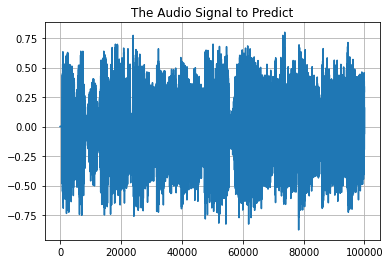

In [22]:
#Example to find prediction coefficients to minimize the mean absolute error using Python Keras
#and 1 Convolutional layer as a predictor.

#Input audio signal X:
audio, samplerate = librosa.load("./SR CUSTOM AMEN VARIATION.wav", sr=None, offset=6)
audio=audio*1.0/np.max(np.abs(audio)) #normalize
    
audiosh=audio[:100000] #shorten the signal for faster optimization,
plt.figure()
plt.plot(audiosh)
plt.title("The Audio Signal to Predict")
plt.grid()

    
X=format_vector2pytorch(audiosh[:-((L-1)*dilation+1)]) #remove last samples 
Y=format_vector2pytorch(audiosh[1:]) #remove first sample, for the signal to predict, 1 sample in the future
    
print("Generate Model:")
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)

import IPython.display as ipd
display(ipd.Audio(audiosh, rate=samplerate));

In [23]:
print("Generate Model:")
#model = generate_model()     # Compile an neural net
model = ConvNet()#.to('cpu')
print("Def. loss function:")
loss_fn = nn.MSELoss(reduction='sum')
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

for epoch in range(6000):
    Ypred=model(X)
    loss=loss_fn(Ypred, Y)
    if epoch%100==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Generate Model:
Def. loss function:
0 12078.67578125
100 4693.01513671875
200 3060.72412109375
300 2762.577880859375
400 2598.6767578125
500 2458.35498046875
600 2337.8974609375
700 2234.371337890625
800 2143.90966796875
900 2062.95849609375
1000 1988.8087158203125
1100 1919.65380859375
1200 1854.421875
1300 1792.5458984375
1400 1733.760498046875
1500 1677.9547119140625
1600 1625.080322265625
1700 1575.10205078125
1800 1527.971923828125
1900 1483.6197509765625
2000 1441.9503173828125
2100 1402.84521484375
2200 1366.166015625
2300 1331.7593994140625
2400 1299.4615478515625
2500 1269.103759765625
2600 1240.5184326171875
2700 1213.54296875
2800 1188.0244140625
2900 1163.8221435546875
3000 1140.8111572265625
3100 1118.88134765625
3200 1097.939208984375
3300 1077.90625
3400 1058.716796875
3500 1040.31689453125
3600 1022.6618041992188
3700 1005.7124633789062
3800 989.4348754882812
3900 973.7963256835938
4000 958.7649536132812
4100 944.3076782226562
4200 930.3890991210938
4300 916.97247314453

In [24]:
torch.save({'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "linpredweights.torch")

In [25]:
#Processing full length signal:
X=format_vector2pytorch(audio[:-((L-1)*dilation+1)]) #remove last samples 
Y=format_vector2pytorch(audio[1:]) #remove first sample
predictions=model(X) # Make Predictions based on the obtained weights, on short audio
#mean squared predicton error:
err= sum((predictions[0,0,:]-Y[0,0,:])**2)/max(Y.shape)
print("mean squared prediction error=", err)
#mean signal power:
sigpow=sum(X[0,0,:]**2)/max(X.shape)
print("mean signal power=", sigpow)
print("Signal to Error Power Ratio:", sigpow/err)
    
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#weight format for Conv1d:
#[0: filter weights, 1: bias for first layer]
#weight: filters of shape: out_channels× in_channelsgroups× kW
weights=ww['layer1.0.weight'][0,0,:]
    
    
print("weights= ", weights)
#print("Predictions[0,0,:]= ", predictions[0,0,:])

mean squared prediction error= tensor(0.0066, grad_fn=<DivBackward0>)
mean signal power= tensor(0.0465)
Signal to Error Power Ratio: tensor(7.0290, grad_fn=<DivBackward0>)
ww= OrderedDict([('layer1.0.weight', tensor([[[ 0.0025, -0.0191,  0.1426, -0.1957,  0.3501, -0.2545,  0.1920,
           0.3456, -0.8477,  1.4693, -1.6821,  1.4386]]]))])
weights=  tensor([ 0.0025, -0.0191,  0.1426, -0.1957,  0.3501, -0.2545,  0.1920,  0.3456,
        -0.8477,  1.4693, -1.6821,  1.4386])


/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


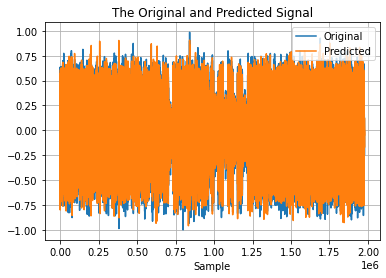

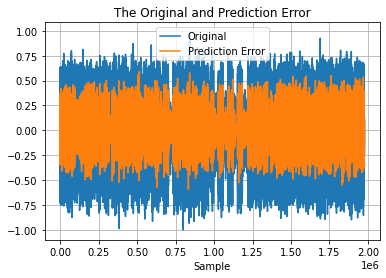

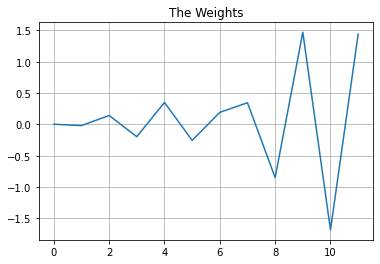

In [26]:
#print("Y=",Y)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#plt.plot(np.array(Y[0,0,:]))
#plt.show()
plt.figure()
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
plt.figure()
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:]-np.array(Y[0,0,:]))
plt.legend(('Original','Prediction Error'))
plt.title('The Original and Prediction Error')
plt.xlabel('Sample')
plt.grid()
plt.figure()
plt.plot(np.array(weights))
plt.title('The Weights')
plt.grid()

In [ ]:
ipd.Audio(predictions.detach().numpy()[0,0,:], rate=samplerate)